<a href="https://colab.research.google.com/github/Tanuja2725/deeplearning/blob/main/5_02_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 4th Feb, 2023
# Objective: Apply LSTM for time-series prediction
#            Develop a simple model to predict stock prices

# Ref: https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn
# https://www.kaggle.com/datasets/akram24/google-stock-price-test


## Call libraries

In [ ]:
# 1.0 Call libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# 1.0.1
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pathlib

In [ ]:
# 1.0.2 Display multiple outputs from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Mount gdrive

In [ ]:
# 2.0 Mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# 2.1 Path to data folder:

path = "/gdrive/MyDrive/colab_data_files/LSTM"

# 2.1.1 Transform to pathlib object:
data_folder=pathlib.Path(path)

## Read train/test data

In [ ]:
# 3.0
dataset_train = pd.read_csv(data_folder / "Google_Stock_Price_Train.csv")
dataset_test = pd.read_csv(data_folder / "Google_Stock_Price_Test.csv")

In [ ]:
# 3.0.1
dataset_train.head()
dataset_train.tail()
print("\n============\n")
dataset_train.shape

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


,Date,Open,High,Low,Close,Volume
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"
1257,12/30/2016,782.75,782.78,770.41,771.82,"1,770,000"


(1258, 6)

## Process data

In [ ]:
# 4.0 We wil only use 'Open' column for prediction:

train_data = dataset_train.iloc[:,1:2]
test_data = dataset_test.iloc[:,1:2]
train_data.head()
print("\n=============\n")
train_data.shape    # (1258, 1)
print("\n=============\n")
test_data.shape     # (20, 1)

,Open
0,325.25
1,331.27
2,329.83
3,328.34
4,322.04


(1258, 1)

(20, 1)

In [ ]:
# 4.1 Normalize data:

mm = MinMaxScaler(feature_range = (0,1))

# 4.1.0 Transformed output is numpy array"
training_set_scaled = mm.fit_transform(train_data)
test_set_scaled = mm.transform(test_data)


## Organize and reshape data
Suppose our data is:<br>
23,34,56,78,93,12,34,67,23
Let timesteps be 3: <br>
Then, we want to have the follwing pieces of train--target:
>`train--target`<br>
>`23,34,56--78`<br>
`34,56,78--93`<br>
`56,78,93--12`<br>
`78,93,12--34`<br>
`93,12,34--67`<br>
`12,34,67--23`<br>

### Experimental code

In [ ]:
# 5.0 Constants
timesteps = 3
data = np.array([23,34,56,78,93,12,34,67,23])

In [ ]:
# 5.1 Organize: 
xtr = []
ytr = []
for i in range(timesteps,len(data)):
  xtr.append(data[i-timesteps:i])
  ytr.append(data[i])

In [ ]:
# 5.2
xtr    # A list of arrays
print("\n==========\n")
ytr

[array([23, 34, 56]),
 array([34, 56, 78]),
 array([56, 78, 93]),
 array([78, 93, 12]),
 array([93, 12, 34]),
 array([12, 34, 67])]

[78, 93, 12, 34, 67, 23]

### Real code


In [ ]:
# 6.0
timesteps = 60
X_train = []
y_train = []

for i in range(timesteps,len(train_data)):
  X_train.append(training_set_scaled[i-60:i,0])
  y_train.append(training_set_scaled[i,0])

In [ ]:
X_train[:3]

array([[[0.08581368],
        [0.09701243],
        [0.09433366],
        [0.09156187],
        [0.07984225],
        [0.0643277 ],
        [0.0585423 ],
        [0.06568569],
        [0.06109085],
        [0.06639259],
        [0.0614257 ],
        [0.07474514],
        [0.02797827],
        [0.02379269],
        [0.02409033],
        [0.0159238 ],
        [0.01078949],
        [0.00967334],
        [0.01642607],
        [0.02100231],
        [0.02280676],
        [0.02273235],
        [0.02810849],
        [0.03212665],
        [0.0433812 ],
        [0.04475779],
        [0.04790163],
        [0.0440695 ],
        [0.04648783],
        [0.04745517],
        [0.04873875],
        [0.03936305],
        [0.04137213],
        [0.04034898],
        [0.04784582],
        [0.04325099],
        [0.04356723],
        [0.04286033],
        [0.04602277],
        [0.05398467],
        [0.05738894],
        [0.05714711],
        [0.05569611],
        [0.04421832],
        [0.04514845],
        [0

In [ ]:
y_train[:3]

array([0.08627874, 0.08471612, 0.07454052])

In [ ]:
# 6.1 Transform to arrays
X_train , y_train = np.array(X_train), np.array(y_train)


In [ ]:
# 6.2 X_train is an array of arrays:

type(X_train)
print("\n========\n")
type(X_train[0])
print("\n========\n")
X_train.shape      # (1198, 60) there are 1198 arrays, each of size 60

numpy.ndarray

numpy.ndarray

(1198, 60)

In [ ]:
# 6.3 Reshape to : (samples,timesteps,noOfFeatures):

X_train= np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape    # (1198, 60, 1)

(1198, 60, 1)

## Model

In [ ]:
# 7.0
model = tf.keras.Sequential()

In [ ]:
# 7.1
model.add(tf.keras.layers.Input(shape = (X_train.shape[1], 1)))

In [ ]:
# 7.2
model.add(tf.keras.layers.LSTM(
                                units = 50,
                                return_sequences = True
                               )
         )

In [ ]:
# 7.3
model.add(tf.keras.layers.Dropout(0.2))

In [ ]:
# 7.4
model.add(tf.keras.layers.LSTM(
                               units = 50,
                               return_sequences = True)
                              )

In [ ]:
# 7.5
model.add(tf.keras.layers.Dropout(0.2))

In [ ]:
# 7.6
model.add(tf.keras.layers.LSTM(units = 50))

In [ ]:
# 7.7
model.add(tf.keras.layers.Dropout(0.1))

In [ ]:
# 7.8
model.add(tf.keras.layers.Dense(1))

In [ ]:
# 7.9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

## Model comilation and fitting

In [ ]:
# 8.0 Compile:
model.compile(optimizer = "adam", loss = "mse")

In [ ]:
# 9.0
model.fit(
          X_train,y_train,
          batch_size = 32,
          epochs = 100
          )

Epoch 1/100
38/38 [==============================] - 9s 91ms/step - loss: 0.0449
Epoch 2/100
38/38 [==============================] - 3s 89ms/step - loss: 0.0041
Epoch 3/100
38/38 [==============================] - 3s 87ms/step - loss: 0.0035
Epoch 4/100
38/38 [==============================] - 3s 87ms/step - loss: 0.0037
Epoch 5/100
38/38 [==============================] - 4s 103ms/step - loss: 0.0032
Epoch 6/100
38/38 [==============================] - 3s 88ms/step - loss: 0.0036
Epoch 7/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0034
Epoch 8/100
38/38 [==============================] - 3s 90ms/step - loss: 0.0034
Epoch 9/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0032
Epoch 10/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0030
Epoch 11/100
38/38 [==============================] - 3s 88ms/step - loss: 0.0028
Epoch 12/100
38/38 [==============================] - 3s 88ms/step - loss: 0.0029
Epoch 13/100
38/38 [====

## MAke predictions

In [ ]:
# 10.0
test_data.shape   # (20, 1)
train_data.shape  # (1258, 1)

(20, 1)

(1258, 1)

In [ ]:
# 10.1 Combined data:
dataset_total=pd.concat([train_data['Open'],test_data['Open']],axis = 0)
dataset_total.shape    # (1278,)

(1278,)

In [ ]:
# 10.2 Data for test predictions:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs.shape   # 80

(80,)

In [ ]:
# 10.3
inputs = inputs.reshape(-1,1)
inputs.shape   # (80, 1)

(80, 1)

In [ ]:
# 11.0 Transform inputs:

inputs = mm.transform(inputs)


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# 11.1 PRepare from inputs data:
X_test = []
for i in range(60,80):
    X_test.append(inputs[i-60:i,0])

len(X_test)    # 20
print("\n===========\n")
X_test[0]
print("\n===========\n")
X_test = np.array(X_test)
X_test.shape   # (20, 60)

20

array([0.9299055 , 0.93113327, 0.92750577, 0.94415507, 0.93876032,
       0.93403527, 0.93483518, 0.9313937 , 0.94636878, 0.96569685,
       0.97510976, 0.95966962, 0.97808617, 1.        , 0.98076494,
       0.97083116, 0.98450406, 0.96054394, 0.9371419 , 0.92841729,
       0.90804747, 0.8771858 , 0.92153434, 0.93809063, 0.93165414,
       0.95254483, 0.88812412, 0.88637547, 0.87032145, 0.88563137,
       0.90743359, 0.91571173, 0.89941588, 0.91805566, 0.9089404 ,
       0.9024853 , 0.89456061, 0.91600938, 0.9132934 , 0.88979835,
       0.86589404, 0.89030062, 0.90335962, 0.89642086, 0.91777662,
       0.93176576, 0.94114145, 0.95762334, 0.96413424, 0.96402262,
       0.96971501, 0.95077759, 0.96294367, 0.96123223, 0.95475854,
       0.95204256, 0.95163331, 0.95725128, 0.93796041, 0.93688146])

(20, 60)

In [ ]:
# 11.2 Reshape X_test:

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_test.shape

(20, 60, 1)

In [ ]:
# 11.3 MAke predictions

pred = model.predict(X_test)

# 11.4 Inverse transform
pred = mm.inverse_transform(pred)

1/1 [==============================] - 1s 1s/step


## Plotting results

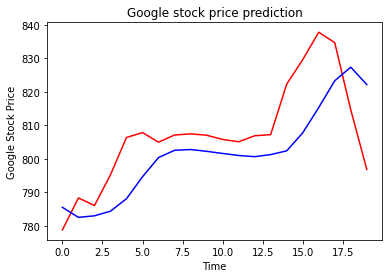

In [ ]:
# 12.0 Plot 
real_stock_price = test_data
plt.plot(real_stock_price, color='red', label = "Real Google Stock Price");
plt.plot(pred, color = 'blue', label = "PRedicted google stock price") ;
plt.title("Google stock price prediction") ;
plt.xlabel("Time") ;
plt.ylabel("Google Stock Price");
plt.show() ;

In [ ]:
################## I am done ##################33